In [2]:
# Import The Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [3]:
# Import The Dataset
df = pd.read_csv('/Users/rezigibtissam/Desktop/KaDomin.csv')
df = df[df['CLI_ID'].notna()]

In [4]:
#Create The RFM Table

In [5]:
arg = df.groupby(['CLI_ID', 'LIBELLE']).agg({'LIBELLE':list, 'PRIX_NET': 'sum', 'MOIS_VENTE': 'max'})
arg['Quantity'] = arg['LIBELLE'].str.len()
del arg['LIBELLE']

In [6]:
arg["TotalSum"] = arg["Quantity"] * arg["PRIX_NET"]

In [7]:
arg.rename(columns = {'MOIS_VENTE': 'Recency',
                            'Quantity': 'Frequency',
                            'TotalSum': 'Monetary'}, inplace=True)
del arg['PRIX_NET']

In [8]:
arg

Recency  Frequency  Monetary
CLI_ID   LIBELLE                                                             
1490281  CR JR PARF BIO.SPE AC.SENT.50ML              10          1      7.45
         EAU MICELLAIRE 3 THES FL200ML                10          1      5.95
         GD JDM4 PAMPLEMOUSSE FL 200ML                10          2      6.66
         GD JDM4 TIARE FL 200ML                       10          1      1.67
13290776 EDT  UN MATIN AU JARDIN  100ML  MUGUET        9          1     13.00
         EDT UN MATIN AU JARDIN 100ML LILAS           12          2     43.18
         GD LILAS FP FL200ML                          12          3     17.28
         LAIT LILAS FP FL200ML                        12          2     19.30
         LAIT VELOUTE COCO PN2 400ML                   9          1      5.50

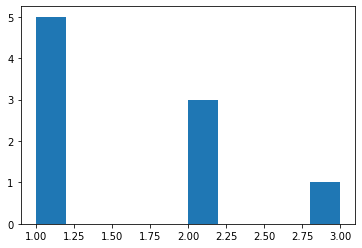

In [9]:
plt.hist(arg['Frequency'], bins=10)
plt.show()

In [11]:
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(arg['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(arg['Frequency'])[0]
customers_fix["Monetary"] = pd.Series(np.cbrt(arg['Monetary'])).values
customers_fix.tail()

,Recency,Frequency,Monetary
4,0.572889,0.000000,2.351335
5,0.578265,0.471286,3.508280
6,0.578265,0.611628,2.585322
7,0.578265,0.471286,2.682373
8,0.572889,0.000000,1.765174


In [12]:
# Initialize the Object
scaler = StandardScaler()
# Fit and Transform The Data
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)
# Assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(customers_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

[-0.  0.  0.]
[1. 1. 1.]


In [15]:
customers_normalized

array([[-0.2602543 , -0.88305407, -0.37502666],
       [-0.2602543 , -0.88305407, -0.59662906],
       [-0.2602543 ,  0.9661512 , -0.48759124],
       [-0.2602543 , -0.88305407, -1.57980502],
       [-1.38982604, -0.88305407,  0.25083063],
       [ 1.27355643,  0.9661512 ,  2.06894371],
       [ 1.27355643,  1.51681677,  0.61853584],
       [ 1.27355643,  0.9661512 ,  0.77104925],
       [-1.38982604, -0.88305407, -0.67030744]])

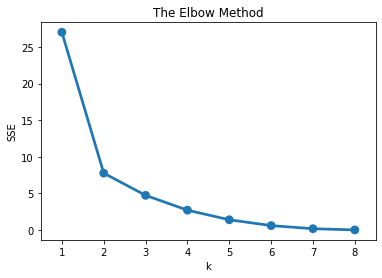

In [16]:
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 9):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [18]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(9,)

In [20]:
arg["Cluster"] = model.labels_
arg.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean', 'count']}).round(2)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          10.0      2.00     6.66     1
1          12.0      2.33    26.59     3
2           9.6      1.00     6.71     5

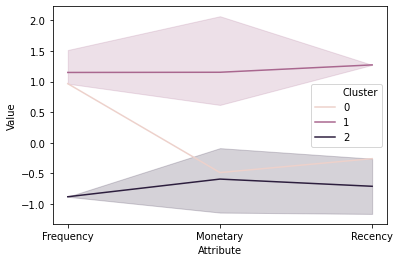

In [21]:
# Create the dataframe
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'Monetary'])
df_normalized['ID'] = arg.index
df_normalized['Cluster'] = model.labels_
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','Monetary'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()
# Visualize it
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)